# PuppySense

인공지능응용 프로젝트

모델학습 (colab 환경설정, 전이 학습 설정 진행)






## 1. Colab 환경설정 (GPU + 라이브러리 설치)

In [1]:
!pip install tensorflow opencv-python matplotlib
!pip install efficientnet
!pip install pandas numpy opencv-python tensorflow kagglehub
!pip install scikit-learn



# 2. 데이터 전처리하기

## 2.1 kaggle 데이터 다운하기

In [53]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import kagglehub

# 1. kagglehub로 실제 경로 다운로드
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")
data_dir = os.path.join(path, 'Dog Emotion')
print("실제 다운로드된 경로:", path)
print("해당 경로 내 파일/폴더:", os.listdir(path))




실제 다운로드된 경로: C:\Users\oculo\.cache\kagglehub\datasets\danielshanbalico\dog-emotion\versions\1
해당 경로 내 파일/폴더: ['Dog Emotion']


## 2.2 테이터 로드


In [ ]:
# 2. labels.csv 경로
labels_csv_path = os.path.join(data_dir, 'labels.csv')
labels_df = pd.read_csv(labels_csv_path)

# 3. 감정 레이블 폴더 이름 불러오기
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f'클래스 목록: {class_names}')

# 4. 레이블 매핑
label_map = {name: idx for idx, name in enumerate(class_names)}

# 5. 이미지 로딩 함수
def load_and_preprocess_img(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"이미지 파일을 불러올 수 없습니다: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (600, 600))
    img = img / 255.0
    return img

# 6. 이미지 및 레이블 로딩
images, labels = [], []
for _, row in labels_df.iterrows():
    img_path = os.path.join(data_dir, row['label'], row['filename'])
    img = load_and_preprocess_img(img_path)
    if img is not None:
        images.append(img)
        labels.append(label_map[row['label']])

# 7. 배열 및 one-hot 인코딩
images = np.array(images)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# 8. 확인
print(f'이미지 개수: {images.shape[0]}, 라벨 개수: {labels.shape[0]}')
print(f'라벨 예시 (one-hot):\n{labels[:5]}')

클래스 목록: ['angry', 'happy', 'relaxed', 'sad']


# 3. test, valid, train set 나누기

In [16]:
from sklearn.model_selection import train_test_split

# 1) train+val / test 분리 (10%를 test로 분리)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2) train / val 분리 (train_val 중 10%를 validation으로 분리)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)


# 4. 전이 학습 모델 구성 (EfficientNetB0 사용)

## 4.1 Feature Extracter로 사전 학습

이미지넷으로 이미 학습된 가중치를 그대로 활용하기 위해서 Feature Extrator를 사용합니다. EfficientNetB0은 선, 모양 색 변화 등 저 수준의 특징을 추출하는 하위층과 귀,입, 꼬리 등 물체의 일부를 감지하는 중간 층, 그리고 전체 물체와 감정등을 추론하는 상위층으로 이루어져 있습니다.Feature Extractor에서 하위, 중간층만 그대로 받아옵니다.

In [18]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # L2 정규화 임포트

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
base_model.trainable = False  # 처음엔 학습하지 않음 (Feature Extractor로 사용)

inputs = Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
outputs = Dense(len(class_names), activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 1차 학습 (기본 모델 고정)
hist = model.fit(
    train_images, train_labels,
    epochs=15,
    validation_data=(val_images, val_labels),
    #callbacks=[early_stop]
    callbacks=[early_stop, reduce_lr]
)


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 99s 763ms/step - accuracy: 0.2509 - loss: 1.7872 - val_accuracy: 0.2500 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 645ms/step - accuracy: 0.2443 - loss: 1.6964 - val_accuracy: 0.2444 - val_loss: 1.5392 - learning_rate: 0.0010
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 638ms/step - accuracy: 0.2570 - loss: 1.6073 - val_accuracy: 0.2500 - val_loss: 1.4461 - learning_rate: 0.0010
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 635ms/step - accuracy: 0.2357 - loss: 1.6074 - val_accuracy: 0.2500 - val_loss: 1.5289 - learning_rate: 0.0010
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 635ms/step - accuracy: 0.2566 - loss: 1.5532 - val_accuracy: 0.2500 - val_loss: 1.4181 - learning_rate: 3.0000e-04
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 655ms/step - accuracy: 0.2397 - loss: 1.5525 - val_accuracy: 0.2500 - val_loss: 1.4144 - learning_rate: 3.0000e-04
Epoch 7/1

## 4.2 상위층 학습

In [21]:
# base_model의 일부 층부터 학습 가능하게 설정
base_model.trainable = True

# (선택) 특정 층까지만 학습되도록 설정하고 싶을 때:
fine_tune_at = len(base_model.layers) - 20  # 맨 끝 20개만 학습 가능하게
for layer in base_model.layers[:fine_tune_at]:
   layer.trainable = False

# 컴파일 다시 (학습 가능한 가중치가 생겼기 때문)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # 전이학습엔 낮은 학습률이 중요
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#2차 학습 (전이 학습)
# hist_fine = model.fit(
#     train_images, train_labels,
#     epochs=20,
#     validation_data=(val_images, val_labels),
#         callbacks=[early_stop, reduce_lr]
# )
# 2차 학습 (전이 학습, 데이터 증강 포함)
# hist_fine = model.fit(
#     train_generator,
#     epochs=20,
#     validation_data=(val_images, val_labels),
#     callbacks=[early_stop, reduce_lr],
#     #steps_per_epoch=len(train_images) // 32
# )


# 5. 데이터 증강학습

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,          # 회전 범위
    width_shift_range=0.1,      # 가로 이동
    height_shift_range=0.1,     # 세로 이동
    shear_range=0.15,            # 전단 변형
    zoom_range=0.2,             # 확대/축소
    horizontal_flip=True,       # 좌우 반전
    fill_mode='nearest'         # 빈 픽셀 채우는 방식
)

# 증강된 데이터로 학습
train_generator = datagen.flow(train_images, train_labels, batch_size=32)

# 모델 학습 (fit 대신 fit_generator 사용)
hist_fine = model.fit(
    train_generator,
    epochs=20,
    validation_data=(val_images, val_labels),
    #callbacks=[early_stop],
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(train_images) // 32
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.2389 - loss: 1.4375 - val_accuracy: 0.2500 - val_loss: 1.3924 - learning_rate: 3.0000e-05
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2500 - loss: 1.4029

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.4029 - val_accuracy: 0.2500 - val_loss: 1.3925 - learning_rate: 3.0000e-05
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.2424 - loss: 1.4123 - val_accuracy: 0.2500 - val_loss: 1.3958 - learning_rate: 3.0000e-05
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3125 - loss: 1.4259 - val_accuracy: 0.2500 - val_loss: 1.3957 - learning_rate: 3.0000e-05
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.2660 - loss: 1.4080 - val_accuracy: 0.2667 - val_loss: 1.3898 - learning_rate: 9.0000e-06
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1875 - loss: 1.4729 - val_accuracy: 0.2667 - val_loss: 1.3897 - learning_rate: 9.0000e-06
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.2642 - loss: 1.3995 - val_accuracy: 0.2528 - val_loss: 1.3866 - learning_rate: 9.0000e-06
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

# 6.테스트셋 평가

## 6.1 테스트셋 평가

In [22]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.2831 - loss: 1.3916
Test Accuracy: 0.2800, Test Loss: 1.3925


Keras 방식의 테스트 정확도 계산

In [23]:
import time
from datetime import datetime

start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"테스트 정확도: {test_acc:.4f}")

end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")




실행 시작: 2025-05-31 19:16:13
테스트 정확도: 0.2800
실행 종료: 2025-05-31 19:16:21
총 실행 시간: 7.89초


## 6.2 모델저장

자신의 드라이브에 저장되는 것이므로 파일 저장후 공용드라이브로 옮겨주어야 합니다.

In [44]:
import os
import time
from datetime import datetime
import tensorflow as tf

# 실행 시간 측정 시작
start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 저장 디렉토리 설정
model_dir = "./models"

# 🔧 파일로 존재하는 경우 삭제
if os.path.exists(model_dir) and not os.path.isdir(model_dir):
    os.remove(model_dir)

# 디렉토리 생성
os.makedirs(model_dir, exist_ok=True)

# 오늘 날짜
today_str = datetime.now().strftime("%Y-%m-%d")

# 저장 경로들
keras_path = os.path.join(model_dir, f"puppySenseModel_{today_str}.keras")
h5_path = os.path.join(model_dir, f"puppySenseModel_{today_str}.h5")

# ✅ 간단한 모델 정의
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ✅ .keras 형식 저장
model.save(keras_path)
print(f"✅ .keras 형식으로 저장됨: {keras_path}")

# ✅ .h5 형식 저장
model.save(h5_path)
print(f"✅ .h5 형식으로 저장됨: {h5_path}")



# 실행 시간 측정 종료
end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")


실행 시작: 2025-05-31 19:24:36
✅ .keras 형식으로 저장됨: ./models\puppySenseModel_2025-05-31.keras
✅ .h5 형식으로 저장됨: ./models\puppySenseModel_2025-05-31.h5
실행 종료: 2025-05-31 19:24:36
총 실행 시간: 0.03초


## 6.3 시각화

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 클래스 이름
class_names = ['angry', 'happy', 'relaxed', 'sad']

# 1. 모델 로드
model = tf.keras.models.load_model('./models')

# 2. 데이터셋 로딩 (예시)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'test_path/',
    image_size=(112, 112),
    batch_size=32
)

# 3. 전체 이미지, 라벨을 numpy 배열로 변환
test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# One-hot encoding 된 라벨인 경우
if test_labels.ndim == 2 and test_labels.shape[1] > 1:
    y_true_class = np.argmax(test_labels, axis=1)
else:
    y_true_class = test_labels  # 정수형 라벨

# 4. 예측
y_pred = model.predict(test_images)
y_pred_class = np.argmax(y_pred, axis=1)

# 5. 시각화
fig = plt.figure(figsize=(15, 10))
for j in range(10):
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[j].astype("uint8"))  # 정규화 해제 필요시 수정

    true_label = class_names[y_true_class[j]]

    prob_text = "\n".join([
        f"{class_names[i]}: {y_pred[j][i]*100:.1f}%" for i in range(len(class_names))
    ])

    ax.text(
        0.5, -0.25,
        f"GT: {true_label}\n{prob_text}",
        size=12,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()



ValueError: File format not supported: filepath=./models. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./models, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [48]:
# 두 히스토리 합치기 (간단히 리스트 이어붙이기)
# for key in hist_fine.history.keys():
#     hist.history[key].extend(hist_fine.history[key])
common_keys = set(hist.history.keys()).intersection(hist_fine.history.keys())
for key in common_keys:
    hist.history[key].extend(hist_fine.history[key])

# 이제 hist.history에 10 epoch의 기록이 모두 들어있음

# 에포크 수 및 히스토리 정보
epochs = len(hist.history['loss'])  # epochs 수를 자동으로 가져옵니다
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

# 손실 그래프
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss, label='train')
plt.plot(xc, val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()
plt.style.use(['classic'])

# 정확도 그래프
plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc, label='train')
plt.plot(xc, val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.style.use(['classic'])

plt.show()


NameError: name 'hist_fine' is not defined

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

       angry       0.24      0.06      0.10       100
       happy       0.27      0.22      0.24       100
     relaxed       0.25      0.74      0.38       100
         sad       0.67      0.02      0.04       100

    accuracy                           0.26       400
   macro avg       0.36      0.26      0.19       400
weighted avg       0.36      0.26      0.19       400



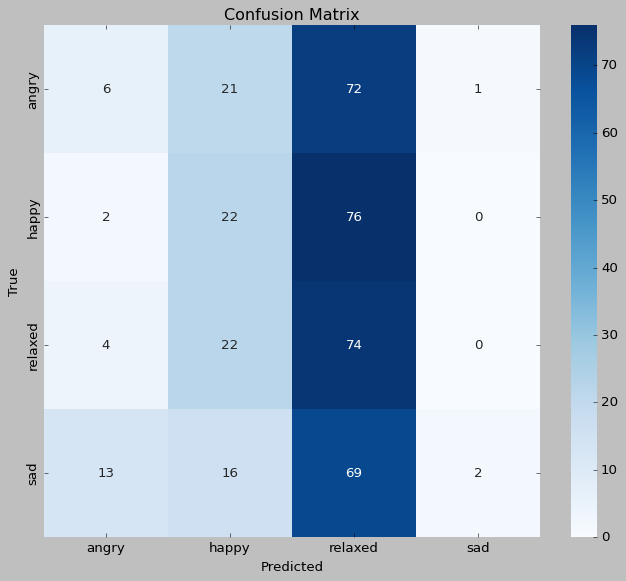

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# 혼동 행렬 시각화
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
